# Great Lunar Lander with DQN

**The Team:**
* Class: DAAA/FT/2B/01
* **Member 1**:
    * Name: Muhammad Faqih Akmal
* **Member 2**:
    * Name: Oh Tien Cheng
* **Member 3**:
    * Name: Wong Zhao Wu

# OpenAI: Lunar Lander V2

<img src="https://miro.medium.com/max/1400/1*W1t--mEISwFTJNXi-qk7vw.png" width="500">

Image from Medium

# Goal of Notebook
The goal of the notebook is to create a Reinforcement Learning model that can land an agent in the Lunar Lander gym environment.



# Introduction

**Reinforcement Learning**

Reinforcement Learning or RL is subset of machine learning that deals with how an agent in an environment choose a sequence of actions in order to maximise a numerical reward signal. It can also be said that RL is trying to find a balance between exploration and exploitation. Exploration is a type of decision where the agent chooses to pick an action that it would not have done. In contrast, exploitation is when the agent follows what it has always done.

**Exanple Application of Reinforcement Learning**

<img src="https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/fsd-1632704256.jpg" width="500">

**Self-driving cars:** Since the invention of cars, people have always dreamed a future where cars could drive on its own and they do not need to worry about driving until they reach their desired destination. This futuristic idea is comming true very soon thanks to the help of Reinforcement Learning. In case of self-driving car, the agent would be the car itself while the environment is the roads along with other vehicles, pedestrians etc. The recent advancements of Reinfocement Learning in such a difficult and complex environment has allows us to inch closer and closer a self-driving car future.

**OpenAI GYM**

OpenAI GYM is a toolkit for developing and comparing reinforcement learning algorithms. They have a gym library that contains a variety of reinforcement learning tasks from walking in 3D space to playing arcade games like PacMan. These environments have a shared and easy-to-use interface where researchers and developers can train and compare agents using different algorithms.

**OpenAI Gym Environment: LunarLander-v2**

<img src="https://wingedsheep.com/content/images/2020/08/lunarlander.gif" width="500">

Lunar Lander is one of OpenAI's gym environment where the agent is a lunar lander that tries to land on a landing pad at coordinate (0,0). These coordinate are the first 2 numbers in the state vector.

There are a total of 4 discrete actions that the lander can do:

1. Do nothing
2. Fire left orientation engine
3. Fire main engine
4. Fire right orientation engine

There are a total of 8 observation space:

1. The coordinates of the lander in x
2. The coordinates of the lander in y
3. Its linear velocities in x
4. Its linear velocities in y
5. Its angle
6. Its angular velocity
7. If left leg is in contact with the ground
8. If right leg is in contact with the ground

Reward system of Lunar Lander:

* Moving from the top of the screen to the landing pad at zero speed can range from 100 to 140 points.
* If the lander moves away from the landing pad, it loses back the landing points.
* The episode finishes if the lander crashes (receives -100 points) or comes to a rest (receives 100 points).
* Each leg ground contact is an additional 10 points.
* Firing main engine -0.3 reward per step.

From the above, we can conclude that the best episode would be the one where the lander lands (**+20** for legs contact) and comes to rest (**+100** for rest) on the center of the landing pad at zero speed (**+140** for landing) with the least steps (**+200** - (count_main_engine_fire * 0.3)).

# Initial Setup

We have created the models in a separate python files under "./model" folder. We also hypertune the models in separate notebooks. This is so that this notebook is clean.

In [1]:
%%capture
!pip install Box2D
!pip install box2d
!pip install box2d-py
!pip install gym[all]
!pip install gym[Box_2D]
!pip install wandb
!pip install knockknock

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/Othercomputers/razer13/0-assignments/ca2/part-b

Mounted at /content/drive
/content/drive/Othercomputers/razer13/0-assignments/ca2/part-b


In [1]:
import gym

import pickle
import plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import load_model

from utils import seed_everything, Experience, ReplayBuffer
from collections import deque

from model.dqn import DQN
from model.ddqn import DoubleDQN as DDQN
from model.sarsa import SARSA

In [4]:
seed_everything(1)

In [8]:
plotly.offline.init_notebook_mode()

In [ ]:
import wandb
wandb.login()
wandb.init()

# Creating the RL Models

In [ ]:
env = gym.make('LunarLander-v2')
env.seed(1)

[1]

### Creating DQN

Deep Q-Network or DQN in short was first proposed by the researchers in Google Deep Mind ([Mnih et al, 2013, 2015](https://www.nature.com/articles/nature14236?wm=book_wap_0005)) which was able to learn 49 different Atari 2600 games simply through a screen. Essentially, Deep Q-Network is a reinforcement learning algorithm that **combines Q-learning with deep neural networks**. This combination allows the agent to learn on complex and high dimensional environments such as video games.

**The Model**

For this notebook, when I create an instance of the DQN class, it will initialise the model and cloning it for the target model. Both models contains a Dense layer with 512 units with a ReLU activation with an input dimension equal to the **number of observation space** in the environment. Then, there is a hidden Dense layer with 256 units with a ReLu activation. This layer is then connected to a final Dense layer with the number of units equal to the number of **possible action space** for the agent. The model is compile with mean squared error with an Adam optimizer that has a configurable learning rate.

**Exploration and Exploitation Trade-off**

During training, for every step in every episode, there is a function that takes in the current state where the model will try to **estimate the q-values for each action** from the current state (Exploitation). However, there is a probability where if a randomly chosen number is lower than epsilon, a random action will be returned (i.e. Exploration).

**Experience Replay**

The returned action will be executed for that step which returns the next state, the reward for that step, whether the episode is done. These variables is then **stored as an experience** in a buffer. A buffer is where the agent keep records of all the state transitions it encountered so it can randomly sample and learn from them later. The memory-buffer used to store this is often referred to as Experience Replay.

**Bellman Equation**

After that, if there is enough experience, the model will sample some experiences for training. The model then use the Bellman Equation for the **model's target value**, where the expected return value is equal to the reward plus the discounted factor multiplied by the maximum value of the next state predicted by the target model. The state and the target value is then fitted into the model.

**Target Network**

The purpose of the target network is to **stabilize the training** of the model. This is because the target network prevents the training process from spiraling around. Since we are fixing the targets for multiple time steps, it allows the online network weights to move consistently towards the targets before an update. In our case, the frequency of updating the target network is configurable.

In [ ]:
# Import Code for DQN
dqn_model = DQN(
    env = env,
    lr =  0.0005,
    gamma = 0.99,
    epsilon = 1,
    epsilon_decay = 0.95,
    target_update_interval = 20,
    log_wandb = True
)

### Creating DDQN

One of the flaws with a normal Deep Q-Network is that the DQN has a tendency to overestimate Q-values, which can hamper its performance in certain environments as the overestimation can result in a suboptimal policy of the agent.

To resolve this overestimation problem, it was proposed in [van Hasselt, Guez, and Silver, “Deep Reinforcement Learning with Double Q-Learning.”](http://arxiv.org/abs/1509.06461) to make use of the target network to calculate the Q-Values, while still using the online (non target) network for choosing actions(Both current and next action). As such, the evaluation of each action's Q Value and the selection of actions is decoupled.

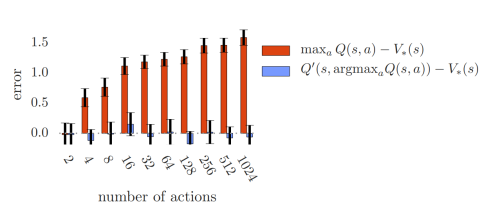

This results in reduced overestimation of the Q values, as shown in the above plot, where the error for the Double DQN update (in blue) is much smaller than that of the DQN update. 

In [ ]:
# Import Code for DDQN
ddqn_model = DDQN(
    env = env,
    lr =  0.0005,
    gamma = 0.99,
    epsilon = 1,
    epsilon_decay = 0.95,
    target_update_interval = 20,
    log_wandb = True
)

### Creating SARSA

The difference between SARSA with DQN and DDQN are quite subtle whereby SARSA is an *on-policy* TD control algorithm. Similar to Q-Learning, SARSA uses the same Bellman's Equation to selecting the optimal policy. What's different is the update rule used to update the Q value.

$$
Q(s,a)=Q(s,a)-\alpha (r+\gamma Q(s',a')-Q(s,a))
$$

In SARSA's update rule, instead of updating the Q-values based on the most optimal next action (i.e. off-policy), SARSA updates the Q-values based on the policy that it uses to select the next action even if during exploration (i.e. on-policy).

Based on this characteristic, the pros of SARSA as an algorithm is the ability to penalize the algorithm when a bad action is taken regardless of whether is it during exploration or exploitation phase during the epsilon-greedy policy strategy.

In the context of lunar lander, SARSA could help to make the algorithm learn to "play safe" during the landing process which is crucial in LunarLander's context as we would want the algorithm to pick the best action to land the aircraft in a safe manner instead of picking the most optimal but it is slightly more risky.

In [ ]:
# Import Code for SARSA
sarsa_model = SARSA(
    env = env,
    lr =  0.0005,
    gamma = 0.99,
    epsilon = 1,
    epsilon_decay = 0.95,
    log_wandb = True
)

# Hyperparparameter Tuning of RL Models

For hyperparameter tuning, we use the "sweep" function in **Weights and Biases** because it is able to coordinate mutiple computers to run full trainings. This reduces the time need to tune our models. For the search technique, we use the classic Random Search to search for the most optimal hyperparameters.

However, we also created a **tuning condition** where if the model goes below a certain point, it will stop the training. In our case, if the model had trained for more than 50 episode and get an average reward below -200, the training will be stopped. This again saves training time since hyperparameters that are obviously bad are quickly stopped.

These are the hypereparameters we are tuning:
1. Learning rate (min = 0.0001, max = 0.01)
2. Epsilon decay (min = 0.95, max = 0.995)
3. Update target interval for DQN and DDQN (1, 5, 10, 20, 30, 50, 100)

### Tuning of DQN

In [ ]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        env = gym.make("LunarLander-v2")
        model = DQN(
            env=env,
            lr=config.lr,
            gamma=config.gamma,
            epsilon=config.epsilon,
            epsilon_decay=config.epsilon_decay,
            target_update_interval=config.update_target_net_interval,
            log_wandb=True,
            tuning_condition=True
        )
        model.train(config.episodes, mean_stopping=True)

In [ ]:
sweep_id = "3fzhy39d"
project_name = "DQN-Tuning"
num_runs = 50

In [ ]:
wandb.agent(sweep_id, train, count=num_runs, entity="onsen", project=project_name)

wandb: Agent Starting Run: gjeg1qqk with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9743088623295352
wandb: 	gamma: 0.99
wandb: 	lr: 0.0015985525875294988
wandb: 	update_target_net_interval: 50


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -311.856 | Avg Reward: -311.856 | e: 0.974
[001] Reward: -153.700 | Avg Reward: -232.778 | e: 0.949
[002] Reward:  -73.105 | Avg Reward: -179.554 | e: 0.925
[003] Reward: -114.267 | Avg Reward: -163.232 | e: 0.901
[004] Reward: -227.426 | Avg Reward: -176.071 | e: 0.878
[005] Reward: -184.283 | Avg Reward: -177.440 | e: 0.855
[006] Reward: -114.382 | Avg Reward: -168.431 | e: 0.833
[007] Reward: -197.133 | Avg Reward: -172.019 | e: 0.812
[008] Reward: -142.000 | Avg Reward: -168.684 | e: 0.791
[009] Reward:  -59.920 | Avg Reward: -157.807 | e: 0.771
[010] Reward: -152.069 | Avg Reward: -157.286 | e: 0.751
[011] Reward:  -81.804 | Avg Reward: -150.995 | e: 0.732
[012] Reward:  -95.463 | Avg Reward: -146.724 | e: 0.713
[013] Reward: -139.780 | Avg Reward: -146.228 | e: 0.695
[014] Reward:  -22.711 | Avg Reward: -137.993 | e: 0.677
[015] Reward: -211.803 | Avg Reward: -142.606 | e: 0.659
[016] Reward:  -26.167 | Avg Reward: -135.757 | e: 0.642
[017] Reward: -122.258 | Avg Re

wandb: Agent Starting Run: e9a9ynz0 with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9851453699121748
wandb: 	gamma: 0.99
wandb: 	lr: 0.0055478628120233615
wandb: 	update_target_net_interval: 5


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -109.724 | Avg Reward: -109.724 | e: 0.985
[001] Reward: -239.204 | Avg Reward: -174.464 | e: 0.971
[002] Reward: -123.205 | Avg Reward: -157.378 | e: 0.956
[003] Reward: -120.151 | Avg Reward: -148.071 | e: 0.942
[004] Reward: -133.821 | Avg Reward: -145.221 | e: 0.928
[005] Reward: -425.884 | Avg Reward: -191.998 | e: 0.914
[006] Reward: -249.521 | Avg Reward: -200.216 | e: 0.901
[007] Reward:  -83.796 | Avg Reward: -185.663 | e: 0.887
[008] Reward: -251.662 | Avg Reward: -192.996 | e: 0.874
[009] Reward: -147.060 | Avg Reward: -188.403 | e: 0.861
[010] Reward: -275.841 | Avg Reward: -196.352 | e: 0.848
[011] Reward: -140.228 | Avg Reward: -191.675 | e: 0.836
[012] Reward: -132.845 | Avg Reward: -187.149 | e: 0.823
[013] Reward: -115.019 | Avg Reward: -181.997 | e: 0.811
[014] Reward:  -70.707 | Avg Reward: -174.578 | e: 0.799
[015] Reward:   15.000 | Avg Reward: -162.729 | e: 0.787
[016] Reward: -308.154 | Avg Reward: -171.284 | e: 0.775
[017] Reward:  -44.393 | Avg Re

wandb: Agent Starting Run: c00wblda with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9643597338760698
wandb: 	gamma: 0.99
wandb: 	lr: 0.004423673999704721
wandb: 	update_target_net_interval: 20


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -526.227 | Avg Reward: -526.227 | e: 0.964
[001] Reward: -298.748 | Avg Reward: -412.488 | e: 0.930
[002] Reward:  -64.699 | Avg Reward: -296.558 | e: 0.897
[003] Reward: -126.676 | Avg Reward: -254.088 | e: 0.865
[004] Reward:  -65.723 | Avg Reward: -216.415 | e: 0.834
[005] Reward: -154.009 | Avg Reward: -206.014 | e: 0.804
[006] Reward: -255.654 | Avg Reward: -213.105 | e: 0.776
[007] Reward:  -95.049 | Avg Reward: -198.348 | e: 0.748
[008] Reward: -448.265 | Avg Reward: -226.117 | e: 0.721
[009] Reward: -110.222 | Avg Reward: -214.527 | e: 0.696
[010] Reward: -216.195 | Avg Reward: -214.679 | e: 0.671
[011] Reward:  -81.855 | Avg Reward: -203.610 | e: 0.647
[012] Reward: -114.894 | Avg Reward: -196.786 | e: 0.624
[013] Reward:  -98.204 | Avg Reward: -189.744 | e: 0.602
[014] Reward: -366.960 | Avg Reward: -201.559 | e: 0.580
[015] Reward: -355.749 | Avg Reward: -211.196 | e: 0.560
[016] Reward: -408.024 | Avg Reward: -222.774 | e: 0.540
[017] Reward: -125.040 | Avg Re

wandb: Agent Starting Run: yboe5qnv with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9805941957816232
wandb: 	gamma: 0.99
wandb: 	lr: 0.0026970544820563392
wandb: 	update_target_net_interval: 5


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -283.605 | Avg Reward: -283.605 | e: 0.981
[001] Reward: -172.698 | Avg Reward: -228.152 | e: 0.962
[002] Reward:  -85.006 | Avg Reward: -180.437 | e: 0.943
[003] Reward: -209.873 | Avg Reward: -187.796 | e: 0.925
[004] Reward: -131.436 | Avg Reward: -176.524 | e: 0.907
[005] Reward:  -82.893 | Avg Reward: -160.919 | e: 0.889
[006] Reward: -108.141 | Avg Reward: -153.379 | e: 0.872
[007] Reward: -449.514 | Avg Reward: -190.396 | e: 0.855
[008] Reward: -110.509 | Avg Reward: -181.520 | e: 0.838
[009] Reward: -100.148 | Avg Reward: -173.382 | e: 0.822
[010] Reward:  -98.680 | Avg Reward: -166.591 | e: 0.806
[011] Reward: -347.901 | Avg Reward: -181.700 | e: 0.790
[012] Reward: -364.809 | Avg Reward: -195.786 | e: 0.775
[013] Reward: -538.943 | Avg Reward: -220.297 | e: 0.760
[014] Reward: -227.338 | Avg Reward: -220.766 | e: 0.745
[015] Reward: -112.835 | Avg Reward: -214.021 | e: 0.731
[016] Reward: -603.348 | Avg Reward: -236.922 | e: 0.717
[017] Reward: -368.124 | Avg Re

wandb: Agent Starting Run: 37ds7hgm with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.951968473056692
wandb: 	gamma: 0.99
wandb: 	lr: 0.006049206698017609
wandb: 	update_target_net_interval: 50


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -335.891 | Avg Reward: -335.891 | e: 0.952
[001] Reward:  -57.960 | Avg Reward: -196.926 | e: 0.906
[002] Reward: -197.994 | Avg Reward: -197.282 | e: 0.863
[003] Reward: -297.786 | Avg Reward: -222.408 | e: 0.821
[004] Reward: -188.868 | Avg Reward: -215.700 | e: 0.782
[005] Reward: -227.715 | Avg Reward: -217.702 | e: 0.744
[006] Reward:  -94.127 | Avg Reward: -200.049 | e: 0.709
[007] Reward: -214.281 | Avg Reward: -201.828 | e: 0.674
[008] Reward: -138.439 | Avg Reward: -194.785 | e: 0.642
[009] Reward: -193.036 | Avg Reward: -194.610 | e: 0.611
[010] Reward: -109.910 | Avg Reward: -186.910 | e: 0.582
[011] Reward:  -87.918 | Avg Reward: -178.661 | e: 0.554
[012] Reward:  -91.341 | Avg Reward: -171.944 | e: 0.527
[013] Reward: -109.542 | Avg Reward: -167.486 | e: 0.502
[014] Reward:  -52.909 | Avg Reward: -159.848 | e: 0.478
[015] Reward: -152.677 | Avg Reward: -159.400 | e: 0.455
[016] Reward:  -74.685 | Avg Reward: -154.416 | e: 0.433
[017] Reward:  -27.767 | Avg Re

wandb: Agent Starting Run: usz7k5oi with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.957467581985955
wandb: 	gamma: 0.99
wandb: 	lr: 0.009589738205663173
wandb: 	update_target_net_interval: 5


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -253.361 | Avg Reward: -253.361 | e: 0.957
[001] Reward: -156.936 | Avg Reward: -205.149 | e: 0.917
[002] Reward:  -90.858 | Avg Reward: -167.052 | e: 0.878
[003] Reward: -239.506 | Avg Reward: -185.165 | e: 0.840
[004] Reward: -318.488 | Avg Reward: -211.830 | e: 0.805
[005] Reward: -253.585 | Avg Reward: -218.789 | e: 0.770
[006] Reward: -195.054 | Avg Reward: -215.398 | e: 0.738
[007] Reward: -227.904 | Avg Reward: -216.962 | e: 0.706
[008] Reward: -214.784 | Avg Reward: -216.720 | e: 0.676
[009] Reward:  -53.318 | Avg Reward: -200.379 | e: 0.648
[010] Reward:  -61.370 | Avg Reward: -187.742 | e: 0.620
[011] Reward:  -93.603 | Avg Reward: -179.897 | e: 0.594
[012] Reward:  -85.465 | Avg Reward: -172.633 | e: 0.568
[013] Reward:  -75.709 | Avg Reward: -165.710 | e: 0.544
[014] Reward: -169.066 | Avg Reward: -165.934 | e: 0.521
[015] Reward:    7.576 | Avg Reward: -155.089 | e: 0.499
[016] Reward:   -7.785 | Avg Reward: -146.424 | e: 0.478
[017] Reward:  -86.745 | Avg Re

wandb: Agent Starting Run: lwym52l9 with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.977675656780409
wandb: 	gamma: 0.99
wandb: 	lr: 0.00570870852324875
wandb: 	update_target_net_interval: 10


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -113.095 | Avg Reward: -113.095 | e: 0.978
[001] Reward: -110.615 | Avg Reward: -111.855 | e: 0.956
[002] Reward:  -12.536 | Avg Reward:  -78.749 | e: 0.935
[003] Reward: -117.737 | Avg Reward:  -88.496 | e: 0.914
[004] Reward: -268.794 | Avg Reward: -124.555 | e: 0.893
[005] Reward: -161.058 | Avg Reward: -130.639 | e: 0.873
[006] Reward: -142.172 | Avg Reward: -132.287 | e: 0.854
[007] Reward: -290.263 | Avg Reward: -152.034 | e: 0.835
[008] Reward: -120.989 | Avg Reward: -148.584 | e: 0.816
[009] Reward: -314.230 | Avg Reward: -165.149 | e: 0.798
[010] Reward:  -35.637 | Avg Reward: -153.375 | e: 0.780
[011] Reward: -252.449 | Avg Reward: -161.631 | e: 0.763
[012] Reward:   -9.373 | Avg Reward: -149.919 | e: 0.746
[013] Reward:  -37.956 | Avg Reward: -141.922 | e: 0.729
[014] Reward:  -82.485 | Avg Reward: -137.959 | e: 0.713
[015] Reward: -130.688 | Avg Reward: -137.505 | e: 0.697
[016] Reward: -450.929 | Avg Reward: -155.941 | e: 0.681
[017] Reward: -156.740 | Avg Re

wandb: Agent Starting Run: b0tqqdhg with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9595083622003894
wandb: 	gamma: 0.99
wandb: 	lr: 0.007361246875651332
wandb: 	update_target_net_interval: 50


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -312.259 | Avg Reward: -312.259 | e: 0.960
[001] Reward: -249.632 | Avg Reward: -280.946 | e: 0.921
[002] Reward: -105.817 | Avg Reward: -222.569 | e: 0.883
[003] Reward: -105.237 | Avg Reward: -193.236 | e: 0.848
[004] Reward: -201.481 | Avg Reward: -194.885 | e: 0.813
[005] Reward: -183.064 | Avg Reward: -192.915 | e: 0.780
[006] Reward: -117.595 | Avg Reward: -182.155 | e: 0.749
[007] Reward: -115.534 | Avg Reward: -173.827 | e: 0.718
[008] Reward:  -55.279 | Avg Reward: -160.655 | e: 0.689
[009] Reward: -114.043 | Avg Reward: -155.994 | e: 0.661
[010] Reward:  -64.081 | Avg Reward: -147.638 | e: 0.635
[011] Reward: -363.230 | Avg Reward: -165.604 | e: 0.609
[012] Reward: -327.957 | Avg Reward: -178.093 | e: 0.584
[013] Reward: -163.283 | Avg Reward: -177.035 | e: 0.561
[014] Reward: -367.028 | Avg Reward: -189.701 | e: 0.538
[015] Reward: -618.563 | Avg Reward: -216.505 | e: 0.516
[016] Reward: -302.653 | Avg Reward: -221.573 | e: 0.495
[017] Reward: -172.850 | Avg Re

wandb: Agent Starting Run: 5n57msb7 with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9765239750907048
wandb: 	gamma: 0.99
wandb: 	lr: 0.00828467018804905
wandb: 	update_target_net_interval: 50


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -271.922 | Avg Reward: -271.922 | e: 0.977
[001] Reward:  -56.774 | Avg Reward: -164.348 | e: 0.954
[002] Reward: -129.351 | Avg Reward: -152.682 | e: 0.931
[003] Reward:  -78.639 | Avg Reward: -134.171 | e: 0.909
[004] Reward: -129.809 | Avg Reward: -133.299 | e: 0.888
[005] Reward: -100.680 | Avg Reward: -127.862 | e: 0.867
[006] Reward: -109.056 | Avg Reward: -125.176 | e: 0.847
[007] Reward: -141.310 | Avg Reward: -127.192 | e: 0.827
[008] Reward: -125.168 | Avg Reward: -126.967 | e: 0.808
[009] Reward: -370.718 | Avg Reward: -151.343 | e: 0.789
[010] Reward: -165.060 | Avg Reward: -152.590 | e: 0.770
[011] Reward: -214.176 | Avg Reward: -157.722 | e: 0.752
[012] Reward: -102.024 | Avg Reward: -153.437 | e: 0.734
[013] Reward: -236.307 | Avg Reward: -159.357 | e: 0.717
[014] Reward:  -95.778 | Avg Reward: -155.118 | e: 0.700
[015] Reward: -475.555 | Avg Reward: -175.145 | e: 0.684
[016] Reward: -290.585 | Avg Reward: -181.936 | e: 0.668
[017] Reward: -228.087 | Avg Re

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aayso0dm with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9541697498734372
wandb: 	gamma: 0.99
wandb: 	lr: 0.009679894459300488
wandb: 	update_target_net_interval: 20


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -280.108 | Avg Reward: -280.108 | e: 0.954
[001] Reward:  -24.499 | Avg Reward: -152.304 | e: 0.910
[002] Reward:  -80.171 | Avg Reward: -128.260 | e: 0.869
[003] Reward: -281.212 | Avg Reward: -166.498 | e: 0.829
[004] Reward:   46.071 | Avg Reward: -123.984 | e: 0.791
[005] Reward:  -94.030 | Avg Reward: -118.992 | e: 0.755
[006] Reward: -267.111 | Avg Reward: -140.151 | e: 0.720
[007] Reward: -132.004 | Avg Reward: -139.133 | e: 0.687
[008] Reward: -565.340 | Avg Reward: -186.489 | e: 0.656
[009] Reward: -328.883 | Avg Reward: -200.729 | e: 0.626
[010] Reward: -478.271 | Avg Reward: -225.960 | e: 0.597
[011] Reward: -405.805 | Avg Reward: -240.947 | e: 0.570
[012] Reward: -334.148 | Avg Reward: -248.116 | e: 0.543
[013] Reward: -384.837 | Avg Reward: -257.882 | e: 0.519
[014] Reward: -321.004 | Avg Reward: -262.090 | e: 0.495
[015] Reward: -242.932 | Avg Reward: -260.893 | e: 0.472
[016] Reward: -546.854 | Avg Reward: -277.714 | e: 0.450
[017] Reward: -459.253 | Avg Re

wandb: Agent Starting Run: 2p5rn5ry with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9766859932313726
wandb: 	gamma: 0.99
wandb: 	lr: 0.005718350698325413
wandb: 	update_target_net_interval: 1


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -134.804 | Avg Reward: -134.804 | e: 0.977
[001] Reward: -150.131 | Avg Reward: -142.467 | e: 0.954
[002] Reward: -185.616 | Avg Reward: -156.850 | e: 0.932
[003] Reward: -125.568 | Avg Reward: -149.029 | e: 0.910
[004] Reward:  -35.430 | Avg Reward: -126.309 | e: 0.889
[005] Reward: -331.888 | Avg Reward: -160.572 | e: 0.868
[006] Reward: -311.861 | Avg Reward: -182.185 | e: 0.848
[007] Reward: -293.474 | Avg Reward: -196.096 | e: 0.828
[008] Reward:  -80.935 | Avg Reward: -183.301 | e: 0.809
[009] Reward:  -61.140 | Avg Reward: -171.084 | e: 0.790
[010] Reward:  -97.803 | Avg Reward: -164.422 | e: 0.771
[011] Reward: -103.152 | Avg Reward: -159.317 | e: 0.753
[012] Reward: -383.849 | Avg Reward: -176.588 | e: 0.736
[013] Reward: -168.357 | Avg Reward: -176.000 | e: 0.719
[014] Reward: -147.400 | Avg Reward: -174.094 | e: 0.702
[015] Reward:  -81.928 | Avg Reward: -168.333 | e: 0.686
[016] Reward: -181.706 | Avg Reward: -169.120 | e: 0.670
[017] Reward: -366.602 | Avg Re

wandb: Agent Starting Run: twxbmqlu with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9526007758397048
wandb: 	gamma: 0.99
wandb: 	lr: 0.001164105840628992
wandb: 	update_target_net_interval: 50


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -104.733 | Avg Reward: -104.733 | e: 0.953
[001] Reward: -154.950 | Avg Reward: -129.841 | e: 0.907
[002] Reward:  -20.008 | Avg Reward:  -93.230 | e: 0.864
[003] Reward: -348.849 | Avg Reward: -157.135 | e: 0.823
[004] Reward: -354.359 | Avg Reward: -196.580 | e: 0.784
[005] Reward: -195.476 | Avg Reward: -196.396 | e: 0.747
[006] Reward: -180.958 | Avg Reward: -194.191 | e: 0.712
[007] Reward: -236.558 | Avg Reward: -199.486 | e: 0.678
[008] Reward:  -84.898 | Avg Reward: -186.754 | e: 0.646
[009] Reward: -176.327 | Avg Reward: -185.712 | e: 0.615
[010] Reward:  -20.355 | Avg Reward: -170.679 | e: 0.586
[011] Reward: -102.986 | Avg Reward: -165.038 | e: 0.558
[012] Reward: -325.301 | Avg Reward: -177.366 | e: 0.532
[013] Reward: -106.267 | Avg Reward: -172.287 | e: 0.507
[014] Reward: -324.838 | Avg Reward: -182.458 | e: 0.483
[015] Reward:  -40.210 | Avg Reward: -173.567 | e: 0.460
[016] Reward: -177.287 | Avg Reward: -173.786 | e: 0.438
[017] Reward: -203.602 | Avg Re

wandb: Agent Starting Run: q85g5xoz with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9570179922510657
wandb: 	gamma: 0.99
wandb: 	lr: 0.00903906159061347
wandb: 	update_target_net_interval: 10


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward:  -71.093 | Avg Reward:  -71.093 | e: 0.957
[001] Reward:  -87.348 | Avg Reward:  -79.221 | e: 0.916
[002] Reward: -420.631 | Avg Reward: -193.024 | e: 0.877
[003] Reward:  -70.783 | Avg Reward: -162.464 | e: 0.839
[004] Reward: -189.678 | Avg Reward: -167.907 | e: 0.803
[005] Reward: -323.976 | Avg Reward: -193.918 | e: 0.768
[006] Reward: -212.792 | Avg Reward: -196.614 | e: 0.735
[007] Reward: -176.593 | Avg Reward: -194.112 | e: 0.704
[008] Reward: -366.118 | Avg Reward: -213.224 | e: 0.673
[009] Reward: -525.313 | Avg Reward: -244.433 | e: 0.644
[010] Reward: -151.268 | Avg Reward: -235.963 | e: 0.617
[011] Reward: -385.308 | Avg Reward: -248.409 | e: 0.590
[012] Reward: -652.420 | Avg Reward: -279.486 | e: 0.565
[013] Reward: -473.429 | Avg Reward: -293.339 | e: 0.541
[014] Reward: -461.553 | Avg Reward: -304.554 | e: 0.517
[015] Reward: -319.240 | Avg Reward: -305.471 | e: 0.495
[016] Reward: -221.847 | Avg Reward: -300.552 | e: 0.474
[017] Reward:  -53.470 | Avg Re

wandb: Agent Starting Run: 9mkswodq with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9703493514254146
wandb: 	gamma: 0.99
wandb: 	lr: 0.0026709320814524
wandb: 	update_target_net_interval: 10


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -136.939 | Avg Reward: -136.939 | e: 0.970
[001] Reward:  -56.395 | Avg Reward:  -96.667 | e: 0.942
[002] Reward: -301.901 | Avg Reward: -165.079 | e: 0.914
[003] Reward: -343.960 | Avg Reward: -209.799 | e: 0.887
[004] Reward: -146.135 | Avg Reward: -197.066 | e: 0.860
[005] Reward: -171.767 | Avg Reward: -192.850 | e: 0.835
[006] Reward: -311.993 | Avg Reward: -209.870 | e: 0.810
[007] Reward: -374.389 | Avg Reward: -230.435 | e: 0.786
[008] Reward: -338.667 | Avg Reward: -242.461 | e: 0.763
[009] Reward: -107.167 | Avg Reward: -228.931 | e: 0.740
[010] Reward: -288.513 | Avg Reward: -234.348 | e: 0.718
[011] Reward:  -66.373 | Avg Reward: -220.350 | e: 0.697
[012] Reward: -190.177 | Avg Reward: -218.029 | e: 0.676
[013] Reward: -254.109 | Avg Reward: -220.606 | e: 0.656
[014] Reward: -144.066 | Avg Reward: -215.504 | e: 0.637
[015] Reward: -175.340 | Avg Reward: -212.993 | e: 0.618
[016] Reward:  -55.571 | Avg Reward: -203.733 | e: 0.599
[017] Reward: -126.221 | Avg Re

wandb: Agent Starting Run: h5scrbuz with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9654372859802328
wandb: 	gamma: 0.99
wandb: 	lr: 0.006539632288446007
wandb: 	update_target_net_interval: 100


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward:  -63.181 | Avg Reward:  -63.181 | e: 0.965
[001] Reward:  -57.279 | Avg Reward:  -60.230 | e: 0.932
[002] Reward: -298.351 | Avg Reward: -139.604 | e: 0.900
[003] Reward: -170.447 | Avg Reward: -147.314 | e: 0.869
[004] Reward:   -1.554 | Avg Reward: -118.162 | e: 0.839
[005] Reward: -183.177 | Avg Reward: -128.998 | e: 0.810
[006] Reward: -126.694 | Avg Reward: -128.669 | e: 0.782
[007] Reward: -221.353 | Avg Reward: -140.254 | e: 0.755
[008] Reward: -389.435 | Avg Reward: -167.941 | e: 0.729
[009] Reward: -110.693 | Avg Reward: -162.216 | e: 0.703
[010] Reward: -257.233 | Avg Reward: -170.854 | e: 0.679
[011] Reward:  -82.560 | Avg Reward: -163.496 | e: 0.656
[012] Reward:  -92.023 | Avg Reward: -157.998 | e: 0.633
[013] Reward:  -88.158 | Avg Reward: -153.010 | e: 0.611
[014] Reward: -627.263 | Avg Reward: -184.627 | e: 0.590
[015] Reward: -243.655 | Avg Reward: -188.316 | e: 0.570
[016] Reward: -265.976 | Avg Reward: -192.884 | e: 0.550
[017] Reward: -194.110 | Avg Re

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jtdf07m1 with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9730224073414075
wandb: 	gamma: 0.99
wandb: 	lr: 0.00845159167456381
wandb: 	update_target_net_interval: 20


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -106.818 | Avg Reward: -106.818 | e: 0.973
[001] Reward:  -99.511 | Avg Reward: -103.165 | e: 0.947
[002] Reward:  -57.611 | Avg Reward:  -87.980 | e: 0.921
[003] Reward:  -92.239 | Avg Reward:  -89.045 | e: 0.896
[004] Reward: -272.551 | Avg Reward: -125.746 | e: 0.872
[005] Reward: -247.933 | Avg Reward: -146.111 | e: 0.849
[006] Reward: -340.174 | Avg Reward: -173.834 | e: 0.826
[007] Reward: -298.504 | Avg Reward: -189.418 | e: 0.803
[008] Reward: -102.907 | Avg Reward: -179.805 | e: 0.782
[009] Reward: -112.881 | Avg Reward: -173.113 | e: 0.761
[010] Reward: -152.003 | Avg Reward: -171.194 | e: 0.740
[011] Reward: -362.384 | Avg Reward: -187.126 | e: 0.720
[012] Reward: -415.153 | Avg Reward: -204.667 | e: 0.701
[013] Reward: -358.792 | Avg Reward: -215.676 | e: 0.682
[014] Reward: -388.821 | Avg Reward: -227.219 | e: 0.664
[015] Reward: -331.682 | Avg Reward: -233.748 | e: 0.646
[016] Reward: -157.983 | Avg Reward: -229.291 | e: 0.628
[017] Reward:   35.392 | Avg Re

wandb: Agent Starting Run: pmjacxue with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9638062263747436
wandb: 	gamma: 0.99
wandb: 	lr: 0.009236769770449576
wandb: 	update_target_net_interval: 50


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -140.382 | Avg Reward: -140.382 | e: 0.964
[001] Reward: -372.333 | Avg Reward: -256.357 | e: 0.929
[002] Reward:  -56.436 | Avg Reward: -189.717 | e: 0.895
[003] Reward:  -56.501 | Avg Reward: -156.413 | e: 0.863
[004] Reward: -147.083 | Avg Reward: -154.547 | e: 0.832
[005] Reward: -142.908 | Avg Reward: -152.607 | e: 0.802
[006] Reward: -286.158 | Avg Reward: -171.686 | e: 0.773
[007] Reward: -341.729 | Avg Reward: -192.941 | e: 0.745
[008] Reward:  -57.320 | Avg Reward: -177.872 | e: 0.718
[009] Reward: -415.734 | Avg Reward: -201.658 | e: 0.692
[010] Reward: -332.802 | Avg Reward: -213.581 | e: 0.667
[011] Reward: -383.431 | Avg Reward: -227.735 | e: 0.643
[012] Reward:  -85.084 | Avg Reward: -216.762 | e: 0.619
[013] Reward: -261.074 | Avg Reward: -219.927 | e: 0.597
[014] Reward: -129.225 | Avg Reward: -213.880 | e: 0.575
[015] Reward:  -84.449 | Avg Reward: -205.791 | e: 0.554
[016] Reward: -140.935 | Avg Reward: -201.976 | e: 0.534
[017] Reward: -134.319 | Avg Re

wandb: Agent Starting Run: r3h3uqzo with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.963228287825774
wandb: 	gamma: 0.99
wandb: 	lr: 0.009523592381047347
wandb: 	update_target_net_interval: 20


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward:  -67.960 | Avg Reward:  -67.960 | e: 0.963
[001] Reward: -278.647 | Avg Reward: -173.303 | e: 0.928
[002] Reward: -138.792 | Avg Reward: -161.800 | e: 0.894
[003] Reward: -283.534 | Avg Reward: -192.233 | e: 0.861
[004] Reward: -155.181 | Avg Reward: -184.823 | e: 0.829
[005] Reward: -240.607 | Avg Reward: -194.120 | e: 0.799
[006] Reward:  -54.627 | Avg Reward: -174.193 | e: 0.769
[007] Reward: -187.898 | Avg Reward: -175.906 | e: 0.741
[008] Reward: -178.858 | Avg Reward: -176.234 | e: 0.714
[009] Reward: -378.859 | Avg Reward: -196.496 | e: 0.688
[010] Reward: -202.777 | Avg Reward: -197.067 | e: 0.662
[011] Reward: -458.304 | Avg Reward: -218.837 | e: 0.638
[012] Reward: -237.636 | Avg Reward: -220.283 | e: 0.614
[013] Reward: -198.036 | Avg Reward: -218.694 | e: 0.592
[014] Reward: -325.462 | Avg Reward: -225.812 | e: 0.570
[015] Reward: -118.853 | Avg Reward: -219.127 | e: 0.549
[016] Reward: -485.946 | Avg Reward: -234.822 | e: 0.529
[017] Reward:  -32.896 | Avg Re

wandb: Agent Starting Run: 7aw1fz0r with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9512537693004894
wandb: 	gamma: 0.99
wandb: 	lr: 0.0016279018091735714
wandb: 	update_target_net_interval: 20


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward:  -86.131 | Avg Reward:  -86.131 | e: 0.951
[001] Reward: -122.446 | Avg Reward: -104.288 | e: 0.905
[002] Reward:  -43.378 | Avg Reward:  -83.985 | e: 0.861
[003] Reward: -300.512 | Avg Reward: -138.117 | e: 0.819
[004] Reward: -227.288 | Avg Reward: -155.951 | e: 0.779
[005] Reward: -122.276 | Avg Reward: -150.338 | e: 0.741
[006] Reward: -140.934 | Avg Reward: -148.995 | e: 0.705
[007] Reward:  -93.187 | Avg Reward: -142.019 | e: 0.670
[008] Reward: -263.769 | Avg Reward: -155.547 | e: 0.638
[009] Reward: -276.130 | Avg Reward: -167.605 | e: 0.607
[010] Reward: -532.260 | Avg Reward: -200.756 | e: 0.577
[011] Reward: -334.349 | Avg Reward: -211.888 | e: 0.549
[012] Reward: -319.593 | Avg Reward: -220.173 | e: 0.522
[013] Reward: -587.078 | Avg Reward: -246.381 | e: 0.497
[014] Reward: -345.057 | Avg Reward: -252.959 | e: 0.473
[015] Reward: -211.781 | Avg Reward: -250.386 | e: 0.450
[016] Reward: -248.631 | Avg Reward: -250.282 | e: 0.428
[017] Reward: -225.295 | Avg Re

wandb: Agent Starting Run: 8b9zgg6x with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9577922776589493
wandb: 	gamma: 0.99
wandb: 	lr: 0.001651274918938225
wandb: 	update_target_net_interval: 100


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -125.230 | Avg Reward: -125.230 | e: 0.958
[001] Reward:  -85.974 | Avg Reward: -105.602 | e: 0.917
[002] Reward:  -49.252 | Avg Reward:  -86.818 | e: 0.879
[003] Reward: -194.198 | Avg Reward: -113.663 | e: 0.842
[004] Reward: -243.238 | Avg Reward: -139.578 | e: 0.806
[005] Reward:  -40.112 | Avg Reward: -123.001 | e: 0.772
[006] Reward:   -0.964 | Avg Reward: -105.567 | e: 0.739
[007] Reward: -108.160 | Avg Reward: -105.891 | e: 0.708
[008] Reward: -140.441 | Avg Reward: -109.730 | e: 0.678
[009] Reward: -224.392 | Avg Reward: -121.196 | e: 0.650
[010] Reward: -142.129 | Avg Reward: -123.099 | e: 0.622
[011] Reward: -130.499 | Avg Reward: -123.716 | e: 0.596
[012] Reward: -179.514 | Avg Reward: -128.008 | e: 0.571
[013] Reward: -221.874 | Avg Reward: -134.713 | e: 0.547
[014] Reward: -132.456 | Avg Reward: -134.562 | e: 0.524
[015] Reward:  -37.397 | Avg Reward: -128.489 | e: 0.502
[016] Reward: -357.519 | Avg Reward: -141.962 | e: 0.480
[017] Reward:  -16.595 | Avg Re

wandb: Agent Starting Run: c2ceynud with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9670469287354048
wandb: 	gamma: 0.99
wandb: 	lr: 0.0037506156576766177
wandb: 	update_target_net_interval: 1


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -108.567 | Avg Reward: -108.567 | e: 0.967
[001] Reward: -192.847 | Avg Reward: -150.707 | e: 0.935
[002] Reward:  -66.860 | Avg Reward: -122.758 | e: 0.904
[003] Reward:   19.537 | Avg Reward:  -87.184 | e: 0.875
[004] Reward:  -86.907 | Avg Reward:  -87.129 | e: 0.846
[005] Reward: -186.236 | Avg Reward: -103.646 | e: 0.818
[006] Reward: -235.281 | Avg Reward: -122.451 | e: 0.791
[007] Reward: -154.470 | Avg Reward: -126.454 | e: 0.765
[008] Reward:  -61.526 | Avg Reward: -119.240 | e: 0.740
[009] Reward: -272.823 | Avg Reward: -134.598 | e: 0.715
[010] Reward: -313.404 | Avg Reward: -150.853 | e: 0.692
[011] Reward: -389.599 | Avg Reward: -170.749 | e: 0.669
[012] Reward: -402.825 | Avg Reward: -188.601 | e: 0.647
[013] Reward: -363.875 | Avg Reward: -201.120 | e: 0.626
[014] Reward: -338.169 | Avg Reward: -210.257 | e: 0.605
[015] Reward: -287.518 | Avg Reward: -215.086 | e: 0.585
[016] Reward: -246.323 | Avg Reward: -216.923 | e: 0.566
[017] Reward: -368.643 | Avg Re

wandb: Agent Starting Run: 2fo4e1qo with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.963118441067021
wandb: 	gamma: 0.99
wandb: 	lr: 0.005696342913301236
wandb: 	update_target_net_interval: 100


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -393.807 | Avg Reward: -393.807 | e: 0.963
[001] Reward: -143.526 | Avg Reward: -268.667 | e: 0.928
[002] Reward: -132.983 | Avg Reward: -223.439 | e: 0.893
[003] Reward: -226.107 | Avg Reward: -224.106 | e: 0.860
[004] Reward:  -58.493 | Avg Reward: -190.983 | e: 0.829
[005] Reward: -258.096 | Avg Reward: -202.169 | e: 0.798
[006] Reward: -130.146 | Avg Reward: -191.880 | e: 0.769
[007] Reward:  -88.790 | Avg Reward: -178.994 | e: 0.740
[008] Reward: -260.612 | Avg Reward: -188.062 | e: 0.713
[009] Reward: -167.512 | Avg Reward: -186.007 | e: 0.687
[010] Reward: -189.449 | Avg Reward: -186.320 | e: 0.661
[011] Reward: -125.783 | Avg Reward: -181.275 | e: 0.637
[012] Reward: -116.616 | Avg Reward: -176.302 | e: 0.614
[013] Reward:  -82.069 | Avg Reward: -169.571 | e: 0.591
[014] Reward:  -45.181 | Avg Reward: -161.278 | e: 0.569
[015] Reward:  -71.819 | Avg Reward: -155.687 | e: 0.548
[016] Reward:  -53.977 | Avg Reward: -149.704 | e: 0.528
[017] Reward:  -41.289 | Avg Re

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ktths326 with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.959334336801774
wandb: 	gamma: 0.99
wandb: 	lr: 0.003178252571117092
wandb: 	update_target_net_interval: 10


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -337.965 | Avg Reward: -337.965 | e: 0.959
[001] Reward: -112.936 | Avg Reward: -225.450 | e: 0.920
[002] Reward: -188.034 | Avg Reward: -212.978 | e: 0.883
[003] Reward: -162.864 | Avg Reward: -200.450 | e: 0.847
[004] Reward: -222.427 | Avg Reward: -204.845 | e: 0.813
[005] Reward:  -90.132 | Avg Reward: -185.726 | e: 0.780
[006] Reward:  -95.038 | Avg Reward: -172.771 | e: 0.748
[007] Reward:  -94.403 | Avg Reward: -162.975 | e: 0.717
[008] Reward: -198.016 | Avg Reward: -166.868 | e: 0.688
[009] Reward:  -88.842 | Avg Reward: -159.066 | e: 0.660
[010] Reward: -131.415 | Avg Reward: -156.552 | e: 0.633
[011] Reward: -114.960 | Avg Reward: -153.086 | e: 0.608
[012] Reward: -127.454 | Avg Reward: -151.114 | e: 0.583
[013] Reward: -107.187 | Avg Reward: -147.977 | e: 0.559
[014] Reward: -168.214 | Avg Reward: -149.326 | e: 0.536
[015] Reward: -109.690 | Avg Reward: -146.849 | e: 0.515
[016] Reward:  -99.703 | Avg Reward: -144.075 | e: 0.494
[017] Reward:  -72.937 | Avg Re

wandb: Agent Starting Run: 9hntt44a with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9665971726319688
wandb: 	gamma: 0.99
wandb: 	lr: 0.00029231696625000024
wandb: 	update_target_net_interval: 10


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -111.495 | Avg Reward: -111.495 | e: 0.967
[001] Reward: -295.932 | Avg Reward: -203.713 | e: 0.934
[002] Reward:  -72.859 | Avg Reward: -160.095 | e: 0.903
[003] Reward: -189.833 | Avg Reward: -167.530 | e: 0.873
[004] Reward: -202.727 | Avg Reward: -174.569 | e: 0.844
[005] Reward: -308.713 | Avg Reward: -196.926 | e: 0.816
[006] Reward:  -62.102 | Avg Reward: -177.666 | e: 0.788
[007] Reward: -135.585 | Avg Reward: -172.406 | e: 0.762
[008] Reward:  -90.041 | Avg Reward: -163.254 | e: 0.737
[009] Reward: -144.546 | Avg Reward: -161.383 | e: 0.712
[010] Reward: -101.582 | Avg Reward: -155.947 | e: 0.688
[011] Reward: -129.236 | Avg Reward: -153.721 | e: 0.665
[012] Reward:  -15.781 | Avg Reward: -143.110 | e: 0.643
[013] Reward:  -92.171 | Avg Reward: -139.472 | e: 0.621
[014] Reward:  -83.794 | Avg Reward: -135.760 | e: 0.601
[015] Reward: -124.161 | Avg Reward: -135.035 | e: 0.581
[016] Reward: -114.003 | Avg Reward: -133.798 | e: 0.561
[017] Reward:  -58.725 | Avg Re

wandb: Agent Starting Run: 9pzgz1w9 with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9787430365217468
wandb: 	gamma: 0.99
wandb: 	lr: 0.00857121379461832
wandb: 	update_target_net_interval: 5


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -284.826 | Avg Reward: -284.826 | e: 0.979
[001] Reward: -319.366 | Avg Reward: -302.096 | e: 0.958
[002] Reward: -281.848 | Avg Reward: -295.346 | e: 0.938
[003] Reward:  -66.351 | Avg Reward: -238.098 | e: 0.918
[004] Reward: -310.443 | Avg Reward: -252.567 | e: 0.898
[005] Reward: -135.670 | Avg Reward: -233.084 | e: 0.879
[006] Reward: -375.677 | Avg Reward: -253.454 | e: 0.860
[007] Reward: -271.935 | Avg Reward: -255.764 | e: 0.842
[008] Reward: -245.356 | Avg Reward: -254.608 | e: 0.824
[009] Reward: -225.167 | Avg Reward: -251.664 | e: 0.807
[010] Reward:  -91.045 | Avg Reward: -237.062 | e: 0.790
[011] Reward: -118.260 | Avg Reward: -227.162 | e: 0.773
[012] Reward: -338.497 | Avg Reward: -235.726 | e: 0.756
[013] Reward: -394.692 | Avg Reward: -247.081 | e: 0.740
[014] Reward:  -83.148 | Avg Reward: -236.152 | e: 0.724
[015] Reward: -436.656 | Avg Reward: -248.683 | e: 0.709
[016] Reward: -322.180 | Avg Reward: -253.007 | e: 0.694
[017] Reward:  -43.704 | Avg Re

wandb: Agent Starting Run: werqc8vn with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.983625883641753
wandb: 	gamma: 0.99
wandb: 	lr: 0.005596658823893329
wandb: 	update_target_net_interval: 5


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -361.099 | Avg Reward: -361.099 | e: 0.984
[001] Reward:  -91.462 | Avg Reward: -226.280 | e: 0.968
[002] Reward: -125.901 | Avg Reward: -192.821 | e: 0.952
[003] Reward:   28.549 | Avg Reward: -137.478 | e: 0.936
[004] Reward: -399.064 | Avg Reward: -189.795 | e: 0.921
[005] Reward:  -87.525 | Avg Reward: -172.750 | e: 0.906
[006] Reward: -203.771 | Avg Reward: -177.182 | e: 0.891
[007] Reward: -105.719 | Avg Reward: -168.249 | e: 0.876
[008] Reward: -259.818 | Avg Reward: -178.423 | e: 0.862
[009] Reward: -349.275 | Avg Reward: -195.509 | e: 0.848
[010] Reward: -119.095 | Avg Reward: -188.562 | e: 0.834
[011] Reward: -333.963 | Avg Reward: -200.679 | e: 0.820
[012] Reward: -105.912 | Avg Reward: -193.389 | e: 0.807
[013] Reward: -108.733 | Avg Reward: -187.342 | e: 0.794
[014] Reward: -380.547 | Avg Reward: -200.222 | e: 0.781
[015] Reward:  -54.405 | Avg Reward: -191.109 | e: 0.768
[016] Reward: -412.156 | Avg Reward: -204.112 | e: 0.755
[017] Reward: -219.577 | Avg Re

wandb: Agent Starting Run: 4c1wsxz1 with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9622543607385292
wandb: 	gamma: 0.99
wandb: 	lr: 0.0071816997018404405
wandb: 	update_target_net_interval: 50


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -118.249 | Avg Reward: -118.249 | e: 0.962
[001] Reward:  -52.223 | Avg Reward:  -85.236 | e: 0.926
[002] Reward: -370.105 | Avg Reward: -180.192 | e: 0.891
[003] Reward: -212.842 | Avg Reward: -188.355 | e: 0.857
[004] Reward: -117.374 | Avg Reward: -174.159 | e: 0.825
[005] Reward:  -87.053 | Avg Reward: -159.641 | e: 0.794
[006] Reward: -210.159 | Avg Reward: -166.858 | e: 0.764
[007] Reward:  -92.185 | Avg Reward: -157.524 | e: 0.735
[008] Reward:  -84.928 | Avg Reward: -149.458 | e: 0.707
[009] Reward:  -16.415 | Avg Reward: -136.153 | e: 0.681
[010] Reward: -114.005 | Avg Reward: -134.140 | e: 0.655
[011] Reward:  -76.500 | Avg Reward: -129.337 | e: 0.630
[012] Reward:  -76.781 | Avg Reward: -125.294 | e: 0.606
[013] Reward: -130.865 | Avg Reward: -125.692 | e: 0.584
[014] Reward: -111.635 | Avg Reward: -124.755 | e: 0.561
[015] Reward: -126.923 | Avg Reward: -124.890 | e: 0.540
[016] Reward: -221.757 | Avg Reward: -130.588 | e: 0.520
[017] Reward: -106.333 | Avg Re

wandb: Agent Starting Run: 7xq8tbz7 with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9840107113750036
wandb: 	gamma: 0.99
wandb: 	lr: 0.007979575449058618
wandb: 	update_target_net_interval: 5


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -215.198 | Avg Reward: -215.198 | e: 0.984
[001] Reward: -344.256 | Avg Reward: -279.727 | e: 0.968
[002] Reward: -438.988 | Avg Reward: -332.814 | e: 0.953
[003] Reward: -127.609 | Avg Reward: -281.513 | e: 0.938
[004] Reward: -136.194 | Avg Reward: -252.449 | e: 0.923
[005] Reward: -127.461 | Avg Reward: -231.618 | e: 0.908
[006] Reward: -177.974 | Avg Reward: -223.954 | e: 0.893
[007] Reward: -117.222 | Avg Reward: -210.613 | e: 0.879
[008] Reward: -346.198 | Avg Reward: -225.678 | e: 0.865
[009] Reward: -113.739 | Avg Reward: -214.484 | e: 0.851
[010] Reward: -206.952 | Avg Reward: -213.799 | e: 0.838
[011] Reward: -139.388 | Avg Reward: -207.598 | e: 0.824
[012] Reward: -213.035 | Avg Reward: -208.016 | e: 0.811
[013] Reward: -195.180 | Avg Reward: -207.100 | e: 0.798
[014] Reward: -241.942 | Avg Reward: -209.422 | e: 0.785
[015] Reward:  -44.952 | Avg Reward: -199.143 | e: 0.773
[016] Reward: -110.847 | Avg Reward: -193.949 | e: 0.760
[017] Reward: -210.993 | Avg Re

wandb: Agent Starting Run: 7mdgkodb with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9896016980339412
wandb: 	gamma: 0.99
wandb: 	lr: 0.005162108062851291
wandb: 	update_target_net_interval: 5


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -434.118 | Avg Reward: -434.118 | e: 0.990
[001] Reward: -173.099 | Avg Reward: -303.608 | e: 0.979
[002] Reward: -265.609 | Avg Reward: -290.942 | e: 0.969
[003] Reward: -239.701 | Avg Reward: -278.131 | e: 0.959
[004] Reward: -153.486 | Avg Reward: -253.202 | e: 0.949
[005] Reward: -213.247 | Avg Reward: -246.543 | e: 0.939
[006] Reward: -328.862 | Avg Reward: -258.303 | e: 0.929
[007] Reward: -144.237 | Avg Reward: -244.045 | e: 0.920
[008] Reward: -387.377 | Avg Reward: -259.970 | e: 0.910
[009] Reward: -112.593 | Avg Reward: -245.233 | e: 0.901
[010] Reward: -118.152 | Avg Reward: -233.680 | e: 0.891
[011] Reward: -194.270 | Avg Reward: -230.396 | e: 0.882
[012] Reward: -181.402 | Avg Reward: -226.627 | e: 0.873
[013] Reward:  -86.354 | Avg Reward: -216.607 | e: 0.864
[014] Reward: -123.394 | Avg Reward: -210.393 | e: 0.855
[015] Reward: -166.479 | Avg Reward: -207.649 | e: 0.846
[016] Reward: -381.268 | Avg Reward: -217.862 | e: 0.837
[017] Reward:  -23.898 | Avg Re

wandb: Agent Starting Run: jzw6jdzi with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9811296544258616
wandb: 	gamma: 0.99
wandb: 	lr: 0.0009408269893628528
wandb: 	update_target_net_interval: 20


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -131.186 | Avg Reward: -131.186 | e: 0.981
[001] Reward: -300.631 | Avg Reward: -215.908 | e: 0.963
[002] Reward:  -70.335 | Avg Reward: -167.384 | e: 0.944
[003] Reward: -176.260 | Avg Reward: -169.603 | e: 0.927
[004] Reward: -199.747 | Avg Reward: -175.632 | e: 0.909
[005] Reward: -158.789 | Avg Reward: -172.825 | e: 0.892
[006] Reward: -105.113 | Avg Reward: -163.151 | e: 0.875
[007] Reward: -106.140 | Avg Reward: -156.025 | e: 0.859
[008] Reward: -111.319 | Avg Reward: -151.058 | e: 0.842
[009] Reward: -294.993 | Avg Reward: -165.451 | e: 0.827
[010] Reward:  -78.889 | Avg Reward: -157.582 | e: 0.811
[011] Reward: -110.622 | Avg Reward: -153.669 | e: 0.796
[012] Reward:  -65.647 | Avg Reward: -146.898 | e: 0.781
[013] Reward:  -95.565 | Avg Reward: -143.231 | e: 0.766
[014] Reward:  -52.622 | Avg Reward: -137.190 | e: 0.751
[015] Reward:   -1.501 | Avg Reward: -128.710 | e: 0.737
[016] Reward:  -52.769 | Avg Reward: -124.243 | e: 0.723
[017] Reward: -118.171 | Avg Re

wandb: Agent Starting Run: 4vf7gpb3 with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9809094575353198
wandb: 	gamma: 0.99
wandb: 	lr: 0.0072046037817169685
wandb: 	update_target_net_interval: 1


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -405.373 | Avg Reward: -405.373 | e: 0.981
[001] Reward: -240.503 | Avg Reward: -322.938 | e: 0.962
[002] Reward: -129.203 | Avg Reward: -258.359 | e: 0.944
[003] Reward: -114.903 | Avg Reward: -222.495 | e: 0.926
[004] Reward: -117.972 | Avg Reward: -201.591 | e: 0.908
[005] Reward: -346.335 | Avg Reward: -225.715 | e: 0.891
[006] Reward: -243.180 | Avg Reward: -228.210 | e: 0.874
[007] Reward:  -99.803 | Avg Reward: -212.159 | e: 0.857
[008] Reward: -168.781 | Avg Reward: -207.339 | e: 0.841
[009] Reward:  -90.520 | Avg Reward: -195.657 | e: 0.825
[010] Reward: -117.692 | Avg Reward: -188.569 | e: 0.809
[011] Reward: -162.002 | Avg Reward: -186.355 | e: 0.794
[012] Reward: -105.497 | Avg Reward: -180.136 | e: 0.778
[013] Reward: -159.435 | Avg Reward: -178.657 | e: 0.763
[014] Reward:  -55.740 | Avg Reward: -170.462 | e: 0.749
[015] Reward:  -36.385 | Avg Reward: -162.083 | e: 0.735
[016] Reward:  -74.519 | Avg Reward: -156.932 | e: 0.721
[017] Reward:  -63.809 | Avg Re

wandb: Agent Starting Run: 0q8y2lkm with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9807808108519736
wandb: 	gamma: 0.99
wandb: 	lr: 0.008197386941529322
wandb: 	update_target_net_interval: 10


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -241.345 | Avg Reward: -241.345 | e: 0.981
[001] Reward: -104.906 | Avg Reward: -173.125 | e: 0.962
[002] Reward: -108.828 | Avg Reward: -151.693 | e: 0.943
[003] Reward: -101.038 | Avg Reward: -139.029 | e: 0.925
[004] Reward: -131.614 | Avg Reward: -137.546 | e: 0.908
[005] Reward: -117.628 | Avg Reward: -134.226 | e: 0.890
[006] Reward: -462.678 | Avg Reward: -181.148 | e: 0.873
[007] Reward:  -93.710 | Avg Reward: -170.218 | e: 0.856
[008] Reward: -224.219 | Avg Reward: -176.218 | e: 0.840
[009] Reward: -106.811 | Avg Reward: -169.278 | e: 0.824
[010] Reward: -385.024 | Avg Reward: -188.891 | e: 0.808
[011] Reward:  -55.511 | Avg Reward: -177.776 | e: 0.792
[012] Reward: -152.060 | Avg Reward: -175.798 | e: 0.777
[013] Reward: -397.495 | Avg Reward: -191.633 | e: 0.762
[014] Reward:  -94.715 | Avg Reward: -185.172 | e: 0.747
[015] Reward: -195.492 | Avg Reward: -185.817 | e: 0.733
[016] Reward: -291.255 | Avg Reward: -192.019 | e: 0.719
[017] Reward: -468.527 | Avg Re

wandb: Agent Starting Run: zyvcova2 with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9681680420301172
wandb: 	gamma: 0.99
wandb: 	lr: 0.009646972411517326
wandb: 	update_target_net_interval: 1


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -468.746 | Avg Reward: -468.746 | e: 0.968
[001] Reward: -245.441 | Avg Reward: -357.093 | e: 0.937
[002] Reward: -145.440 | Avg Reward: -286.542 | e: 0.908
[003] Reward: -128.812 | Avg Reward: -247.110 | e: 0.879
[004] Reward: -229.571 | Avg Reward: -243.602 | e: 0.851
[005] Reward:  -70.138 | Avg Reward: -214.691 | e: 0.824
[006] Reward:  -89.676 | Avg Reward: -196.832 | e: 0.797
[007] Reward: -130.261 | Avg Reward: -188.511 | e: 0.772
[008] Reward: -139.565 | Avg Reward: -183.072 | e: 0.747
[009] Reward: -289.310 | Avg Reward: -193.696 | e: 0.724
[010] Reward: -385.589 | Avg Reward: -211.141 | e: 0.701
[011] Reward:  -70.837 | Avg Reward: -199.449 | e: 0.678
[012] Reward: -120.550 | Avg Reward: -193.380 | e: 0.657
[013] Reward:  -96.094 | Avg Reward: -186.431 | e: 0.636
[014] Reward:  -40.999 | Avg Reward: -176.735 | e: 0.616
[015] Reward: -117.231 | Avg Reward: -173.016 | e: 0.596
[016] Reward:  -88.157 | Avg Reward: -168.025 | e: 0.577
[017] Reward:  -53.035 | Avg Re

wandb: Agent Starting Run: u4sir0ff with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.970367953291368
wandb: 	gamma: 0.99
wandb: 	lr: 0.001322556504600355
wandb: 	update_target_net_interval: 5


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward:  -65.234 | Avg Reward:  -65.234 | e: 0.970
[001] Reward: -303.445 | Avg Reward: -184.339 | e: 0.942
[002] Reward: -170.138 | Avg Reward: -179.606 | e: 0.914
[003] Reward: -185.403 | Avg Reward: -181.055 | e: 0.887
[004] Reward: -258.859 | Avg Reward: -196.616 | e: 0.860
[005] Reward:  -80.735 | Avg Reward: -177.302 | e: 0.835
[006] Reward: -511.560 | Avg Reward: -225.053 | e: 0.810
[007] Reward:  -75.399 | Avg Reward: -206.346 | e: 0.786
[008] Reward:  -10.577 | Avg Reward: -184.594 | e: 0.763
[009] Reward: -408.444 | Avg Reward: -206.979 | e: 0.740
[010] Reward:  -36.037 | Avg Reward: -191.439 | e: 0.718
[011] Reward: -181.598 | Avg Reward: -190.619 | e: 0.697
[012] Reward: -330.354 | Avg Reward: -201.368 | e: 0.676
[013] Reward: -177.043 | Avg Reward: -199.630 | e: 0.656
[014] Reward: -209.914 | Avg Reward: -200.316 | e: 0.637
[015] Reward: -102.744 | Avg Reward: -194.218 | e: 0.618
[016] Reward: -139.987 | Avg Reward: -191.028 | e: 0.600
[017] Reward: -462.332 | Avg Re

### Tuning of DDQN

In [ ]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        env = gym.make("LunarLander-v2")
        model = DDQN(
            env,
            config.lr,
            config.gamma,
            config.epsilon,
            config.epsilon_decay,
            config.update_target_net_interval,
            log_wandb=True,
            tuning_condition=True,
        )
        model.train(config.episodes, mean_stopping=False)

In [ ]:
sweep_id = "tctxqok8"
project_name = "DDQN-Tuning"
num_runs = 50

In [ ]:
wandb.agent(sweep_id, train, count=num_runs, entity="onsen", project=project_name)

wandb: Agent Starting Run: d8gnpa8r with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.993066335574123
wandb: 	gamma: 0.99
wandb: 	lr: 0.0050885526774758685
wandb: 	update_target_net_interval: 3
wandb: Currently logged in as: aqilakmal (use `wandb login --relogin` to force relogin)


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[000] Reward: -271.817 | Avg Reward: -271.817 | e: 0.993
[001] Reward: -101.205 | Avg Reward: -186.511 | e: 0.986
[002] Reward: -335.076 | Avg Reward: -236.033 | e: 0.979
[003] Reward: -162.869 | Avg Reward: -217.742 | e: 0.973
[004] Reward: -316.190 | Avg Reward: -237.432 | e: 0.966
[005] Reward:  -85.630 | Avg Reward: -212.131 | e: 0.959
[006] Reward: -349.712 | Avg Reward: -231.786 | e: 0.952
[007] Reward:  -94.273 | Avg Reward: -214.597 | e: 0.946
[008] Reward: -100.664 | Avg Reward: -201.937 | e: 0.939
[009] Reward: -127.179 | Avg Reward: -194.462 | e: 0.933
[010] Reward: -449.778 | Avg Reward: -217.672 | e: 0.926
[011] Reward: -128.853 | Avg Reward: -210.270 | e: 0.920
[012] Reward: -109.137 | Avg Reward: -202.491 | e: 0.914
[013] Reward: -215.994 | Avg Reward: -203.455 | e: 0.907
[014] Reward: -194.903 | Avg Reward: -202.885 | e: 0.901
[015] Reward: -171.658 | Avg Reward: -200.934 | e: 0.895
[016] Reward: -371.225 | Avg Reward: -210.951 | e: 0.888
[017] Reward: -209.958 | Avg Re

### Tuning of SARSA

In [ ]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        env = gym.make("LunarLander-v2")
        model = SARSA(
            env=env,
            lr=config.lr,
            gamma=config.gamma,
            epsilon=config.epsilon,
            epsilon_decay=config.epsilon_decay,
            log_wandb=True,
            tuning_condition=True,
        )
        model.train(config.episodes, mean_stopping=False)

In [ ]:
sweep_id = "f1zo1g3l"
project_name = "SARSA-Tuning"
num_runs = 50

In [ ]:
wandb.agent(sweep_id, train, count=num_runs, entity="onsen", project=project_name)


wandb: Agent Starting Run: 9vvredwu with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.961077339888314
wandb: 	gamma: 0.99
wandb: 	lr: 0.007278170416668749
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-02-10 08:45:54.735860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tiencheng/GitHub/Great-Lunar-Lander/env/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-10 08:45:54.735888: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -240.924 | Avg Reward: -240.924 | e: 0.961 | Episode Length:   79
[001] Reward: -157.771 | Avg Reward: -199.348 | e: 0.924 | Episode Length:   93
[002] Reward: -267.913 | Avg Reward: -222.203 | e: 0.888 | Episode Length:   83
[003] Reward: -270.423 | Avg Reward: -234.258 | e: 0.853 | Episode Length:  102
[004] Reward: -411.768 | Avg Reward: -269.760 | e: 0.820 | Episode Length:   85
[005] Reward: -104.930 | Avg Reward: -242.288 | e: 0.788 | Episode Length:  112
[006] Reward: -346.202 | Avg Reward: -257.133 | e: 0.757 | Episode Length:  148
[007] Reward: -188.794 | Avg Reward: -248.591 | e: 0.728 | Episode Length:   60
[008] Reward: -109.301 | Avg Reward: -233.114 | e: 0.700 | Episode Length:  116
[009] Reward: -268.174 | Avg Reward: -236.620 | e: 0.672 | Episode Length:   95
[010] Reward: -278.871 | Avg Reward: -240.461 | e: 0.646 | Episode Length:   91
[011] Reward:    9.035 | Avg Reward: -219.670 | e: 0.621 | Episode Length:  124
[012] Reward:  -76.137 | Avg Reward: -20

2022-02-10 08:49:06.470047: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-02-10 08:49:06.481326: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


[029] Reward: -203.099 | Avg Reward: -252.143 | e: 0.304 | Episode Length:   54
[030] Reward:  -87.683 | Avg Reward: -246.838 | e: 0.292 | Episode Length:   99


2022-02-10 08:49:16.365476: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


[031] Reward:  -75.699 | Avg Reward: -241.490 | e: 0.281 | Episode Length:   77
[032] Reward: -109.918 | Avg Reward: -237.503 | e: 0.270 | Episode Length:  137
[033] Reward: -466.705 | Avg Reward: -244.244 | e: 0.259 | Episode Length:   68
[034] Reward: -138.387 | Avg Reward: -241.220 | e: 0.249 | Episode Length:   97
[035] Reward: -152.160 | Avg Reward: -238.746 | e: 0.239 | Episode Length:   97
[036] Reward: -124.059 | Avg Reward: -235.646 | e: 0.230 | Episode Length:   76
[037] Reward: -260.373 | Avg Reward: -236.297 | e: 0.221 | Episode Length:  144
[038] Reward: -133.134 | Avg Reward: -233.652 | e: 0.213 | Episode Length:   84
[039] Reward:  -84.874 | Avg Reward: -229.932 | e: 0.204 | Episode Length:   81
[040] Reward: -219.303 | Avg Reward: -229.673 | e: 0.196 | Episode Length:  106
[041] Reward: -427.936 | Avg Reward: -234.394 | e: 0.189 | Episode Length:  110
[042] Reward: -281.576 | Avg Reward: -235.491 | e: 0.181 | Episode Length:   91
[043] Reward: -139.638 | Avg Reward: -23

wandb: Agent Starting Run: 8tskbwty with config:
wandb: 	episodes: 500
wandb: 	epsilon: 1
wandb: 	epsilon_decay: 0.9698069345435544
wandb: 	gamma: 0.99
wandb: 	lr: 0.007451520044093457
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-02-10 08:52:56.407781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tiencheng/GitHub/Great-Lunar-Lander/env/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-10 08:52:56.407837: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epsilon_decay' was locked by 'sweep' (ignored update).


[000] Reward: -175.017 | Avg Reward: -175.017 | e: 0.970 | Episode Length:   62
[001] Reward: -108.289 | Avg Reward: -141.653 | e: 0.941 | Episode Length:  106
[002] Reward: -100.604 | Avg Reward: -127.970 | e: 0.912 | Episode Length:   93
[003] Reward: -194.442 | Avg Reward: -144.588 | e: 0.885 | Episode Length:  100
[004] Reward: -157.087 | Avg Reward: -147.088 | e: 0.858 | Episode Length:   89
[005] Reward: -158.170 | Avg Reward: -148.935 | e: 0.832 | Episode Length:   73
[006] Reward: -222.048 | Avg Reward: -159.380 | e: 0.807 | Episode Length:  136
[007] Reward: -123.665 | Avg Reward: -154.915 | e: 0.782 | Episode Length:  168
[008] Reward: -114.320 | Avg Reward: -150.405 | e: 0.759 | Episode Length:  108
[009] Reward: -125.600 | Avg Reward: -147.924 | e: 0.736 | Episode Length:   90
[010] Reward: -106.576 | Avg Reward: -144.165 | e: 0.714 | Episode Length:  104
[011] Reward: -380.467 | Avg Reward: -163.857 | e: 0.692 | Episode Length:  126
[012] Reward:  -78.212 | Avg Reward: -15

2022-02-10 09:19:10.933616: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


[059] Reward:   -7.370 | Avg Reward:  -50.311 | e: 0.159 | Episode Length:  226
[060] Reward:  224.971 | Avg Reward:  -45.798 | e: 0.154 | Episode Length:  642
[061] Reward:   22.579 | Avg Reward:  -44.695 | e: 0.149 | Episode Length:  198
[062] Reward:  -41.964 | Avg Reward:  -44.652 | e: 0.145 | Episode Length:  251
[063] Reward:  -25.686 | Avg Reward:  -44.355 | e: 0.141 | Episode Length:  108
[064] Reward:   25.181 | Avg Reward:  -43.285 | e: 0.136 | Episode Length:  311
[065] Reward:  206.230 | Avg Reward:  -39.505 | e: 0.132 | Episode Length:  671
[066] Reward:  224.859 | Avg Reward:  -35.559 | e: 0.128 | Episode Length:  364
[067] Reward: -167.733 | Avg Reward:  -37.503 | e: 0.124 | Episode Length:  837
[068] Reward:  164.462 | Avg Reward:  -34.576 | e: 0.121 | Episode Length:  469
[069] Reward:  -41.219 | Avg Reward:  -34.671 | e: 0.117 | Episode Length:  438
[070] Reward:  -38.918 | Avg Reward:  -34.731 | e: 0.113 | Episode Length:  212
[071] Reward:  101.304 | Avg Reward:  -3

# Final Training of RL Models

After hyperparameter tuning, we pick the best hyperparameters and train the three models one last time. For the final training, we train for 1000 episodes with the best hyperparameters.

### Final Training DQN

In [ ]:
env = gym.make('LunarLander-v2')

# set seeds
env.seed(1)

# setting up params
lr = 0.0004233541071584581
epsilon = 1.0
epsilon_decay = 0.9524257785303656
gamma = 0.99
training_episodes = 1000
target_update_interval = 20

# create new deep q-network instance
model = DQN(
    env=env, 
    lr=lr, 
    gamma=gamma, 
    epsilon=epsilon, 
    epsilon_decay=epsilon_decay, 
    target_update_interval=target_update_interval, 
    log_wandb=True,
    save_path = './saved-models/dqn/final_run_dqn.h5'
)

model.train(training_episodes, True)

[000] Reward:  -99.215 | Avg Reward:  -99.215 | e: 0.952
[001] Reward: -154.849 | Avg Reward: -127.032 | e: 0.907
[002] Reward: -137.147 | Avg Reward: -130.404 | e: 0.864
[003] Reward:  -84.751 | Avg Reward: -118.990 | e: 0.823
[004] Reward:  -93.348 | Avg Reward: -113.862 | e: 0.784
[005] Reward: -320.058 | Avg Reward: -148.228 | e: 0.746
[006] Reward:  -10.541 | Avg Reward: -128.558 | e: 0.711
[007] Reward:  -92.205 | Avg Reward: -124.014 | e: 0.677
[008] Reward: -169.042 | Avg Reward: -129.017 | e: 0.645
[009] Reward: -471.986 | Avg Reward: -163.314 | e: 0.614
[010] Reward: -115.642 | Avg Reward: -158.980 | e: 0.585
[011] Reward: -221.081 | Avg Reward: -164.155 | e: 0.557
[012] Reward: -487.282 | Avg Reward: -189.011 | e: 0.531
[013] Reward: -306.477 | Avg Reward: -197.402 | e: 0.505
[014] Reward:  -72.492 | Avg Reward: -189.074 | e: 0.481
[015] Reward: -131.350 | Avg Reward: -185.467 | e: 0.458
[016] Reward: -111.206 | Avg Reward: -181.098 | e: 0.437
[017] Reward: -196.544 | Avg Re

### Final Training DDQN

In [ ]:
env = gym.make('LunarLander-v2')

# set seeds
env.seed(1)

# setting up params
lr = 0.000926264285154698
epsilon = 1.0
epsilon_decay = 0.9608260526646418
gamma = 0.99
training_episodes = 1000
target_update_interval = 5

# create new DDQN instance
model = DDQN(
    env=env, 
    lr=lr, 
    gamma=gamma, 
    epsilon=epsilon, 
    epsilon_decay=epsilon_decay, 
    target_update_interval=target_update_interval, 
    log_wandb=True
)

model.train(training_episodes, True)

[000] Reward:  -99.215 | Avg Reward:  -99.215 | e: 0.952
[001] Reward: -154.849 | Avg Reward: -127.032 | e: 0.907
[002] Reward: -137.147 | Avg Reward: -130.404 | e: 0.864
[003] Reward:  -84.751 | Avg Reward: -118.990 | e: 0.823
[004] Reward:  -93.348 | Avg Reward: -113.862 | e: 0.784
[005] Reward: -320.058 | Avg Reward: -148.228 | e: 0.746
[006] Reward:  -10.541 | Avg Reward: -128.558 | e: 0.711
[007] Reward:  -92.205 | Avg Reward: -124.014 | e: 0.677
[008] Reward: -169.042 | Avg Reward: -129.017 | e: 0.645
[009] Reward: -471.986 | Avg Reward: -163.314 | e: 0.614
[010] Reward: -115.642 | Avg Reward: -158.980 | e: 0.585
[011] Reward: -221.081 | Avg Reward: -164.155 | e: 0.557
[012] Reward: -487.282 | Avg Reward: -189.011 | e: 0.531
[013] Reward: -306.477 | Avg Reward: -197.402 | e: 0.505
[014] Reward:  -72.492 | Avg Reward: -189.074 | e: 0.481
[015] Reward: -131.350 | Avg Reward: -185.467 | e: 0.458
[016] Reward: -111.206 | Avg Reward: -181.098 | e: 0.437
[017] Reward: -196.544 | Avg Re

### Final Training SARSA

In [ ]:
env = gym.make('LunarLander-v2')

# set seeds
env.seed(1)

# setting up params
lr = 0.0013990305980660664
epsilon = 1.0
epsilon_decay = 0.9705003565261908
gamma = 0.99
training_episodes = 1000

# create new sarsa instance
model = SARSA(
    env, 
    lr, 
    gamma, 
    epsilon, 
    epsilon_decay, 
    log_wandb=True
)

model.train(training_episodes, max_num_steps = 1000)

[000] Reward: -362.521 | Avg Reward: -362.521 | e: 0.995 | Episode Length:  109
[001] Reward:  -75.289 | Avg Reward: -218.905 | e: 0.990 | Episode Length:   79
[002] Reward: -273.729 | Avg Reward: -237.180 | e: 0.985 | Episode Length:   90
[003] Reward: -101.017 | Avg Reward: -203.139 | e: 0.980 | Episode Length:   73
[004] Reward: -165.096 | Avg Reward: -195.530 | e: 0.975 | Episode Length:   67
[005] Reward:  -92.769 | Avg Reward: -178.403 | e: 0.970 | Episode Length:   80
[006] Reward:  -99.582 | Avg Reward: -167.143 | e: 0.966 | Episode Length:   86
[007] Reward: -283.434 | Avg Reward: -181.679 | e: 0.961 | Episode Length:   84
[008] Reward:  -96.772 | Avg Reward: -172.245 | e: 0.956 | Episode Length:   84
[009] Reward: -113.977 | Avg Reward: -166.418 | e: 0.951 | Episode Length:   91
[010] Reward: -223.862 | Avg Reward: -171.641 | e: 0.946 | Episode Length:   78
[011] Reward:  -95.167 | Avg Reward: -165.268 | e: 0.942 | Episode Length:   68
[012] Reward:  -47.101 | Avg Reward: -15

KeyboardInterrupt: 

# Evaluation of RL Models

After training our RL models, we will now evaluate all of them to see how they stack up against one another. To evaluate the models, we follow the following procedure:
- Set up the Lunar Lander environment with the exact same seed
- Have the model go through 1000 episodes
    - During evaluation, the model does not employ an epsilon greedy strategy, but instead employs a completely greedy strategy, always selecting the action with the highest Q value.
    - The online network is used throughout to select the actions and calculate Q values
    - We record the following:
        - The average reward over the 1000 episodes
        - The average episode length over the 1000 episodes
        - The number of times the Lander landed successfully (reward > 100)
        - A recording of every 25 episodes for observation

In [ ]:
%%capture
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

In [ ]:
import wandb
import pickle
from pyvirtualdisplay import Display
from utils import seed_everything, evaluate_model

In [ ]:
# Use Google Colab
# use False with Xvfb
d = Display(visible=False, size=(1024, 768)) # (1400, 900)
d.start()
!echo $DISPLAY

:1001


### Evaluate DQN
The DQN model performs well, with an average reward of 247, and a mean episode length of 252. It lands most of the time, with a failure rate of 5%.

In [ ]:
seed_everything(1)
model_name = "dqn-final"
model_path = "./saved-models/dqn/final_run_dqn.h5"

In [ ]:
wandb.init(
    entity="onsen",
    project="Evaluation"
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%%time
metrics_dict = evaluate_model(
    model_name = model_name,
    model_path = model_path,
    num_test_eps = 1000,
    save_video = True,
    log_wandb = True
)

Evaluation Config:             
- Model name: dqn-final             
- Model path: ./saved-models/dqn/final_run_dqn.h5             
- No of test episodes/model: 1000             
- Save video: True             
- Video save frequency: 25             
- Video folder: ./eval-video

Evaluating dqn-final...
dqn-final | [001] | R: 272.161 | Mean(R): 272.161 | EpsL: 217 | Mean(EpsL): 217 | Land: True | Count(Land): 1 | Percent(Land): 100.00%
dqn-final | [002] | R: 258.939 | Mean(R): 265.550 | EpsL: 223 | Mean(EpsL): 220 | Land: True | Count(Land): 2 | Percent(Land): 100.00%
dqn-final | [003] | R: 278.369 | Mean(R): 269.823 | EpsL: 235 | Mean(EpsL): 225 | Land: True | Count(Land): 3 | Percent(Land): 100.00%
dqn-final | [004] | R: 304.958 | Mean(R): 278.606 | EpsL: 264 | Mean(EpsL): 235 | Land: True | Count(Land): 4 | Percent(Land): 100.00%
dqn-final | [005] | R: 249.947 | Mean(R): 272.875 | EpsL: 199 | Mean(EpsL): 228 | Land: True | Count(Land): 5 | Percent(Land): 100.00%
dqn-final | [006] | 

Metrics of dqn-final saved as eval_metrics_dict_dqn-final_20220211_162246.p
CPU times: user 2h 42min 47s, sys: 6min 47s, total: 2h 49min 34s
Wall time: 2h 46min 18s


### Evaluate DDQN
The DDQN model performs extremely well, better than the DQN model as it has a higher average reward of 252, and a lower failure rate of around 1-2%. However, the agent appears to be more cautious than the DQN model, having a higher mean episode length of 357, suggesting it takes longer to land to attain the lower failure rate of the lander. It is likely that the DDQN managed to perform better because it had a better estimate of the Q-values of actions than the normal DQN, and so by Bellman's Equation of Optimality, it was able to get a more optimal policy as compared to the DQN.

In [ ]:
seed_everything(1)
model_name = "ddqn-final"
model_path = "./saved-models/ddqn/ddqn.h5"

In [ ]:
wandb.init(
    entity="onsen",
    project="Evaluation"
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%%time
metrics_dict = evaluate_model(
    model_name = model_name,
    model_path = model_path,
    num_test_eps = 1000,
    save_video = True,
    log_wandb = True
)

Evaluation Config:             
- Model name: ddqn-final             
- Model path: ./saved-models/ddqn/ddqn.h5             
- No of test episodes/model: 1000             
- Save video: True             
- Video save frequency: 25             
- Video folder: ./eval-video

Evaluating ddqn-final...
ddqn-final | [001] | R: 288.498 | Mean(R): 288.498 | EpsL: 269 | Mean(EpsL): 269 | Land: True | Count(Land): 1 | Percent(Land): 100.00%
ddqn-final | [002] | R: 279.496 | Mean(R): 283.997 | EpsL: 295 | Mean(EpsL): 282 | Land: True | Count(Land): 2 | Percent(Land): 100.00%
ddqn-final | [003] | R: 228.354 | Mean(R): 265.450 | EpsL: 528 | Mean(EpsL): 364 | Land: True | Count(Land): 3 | Percent(Land): 100.00%
ddqn-final | [004] | R: 273.678 | Mean(R): 267.507 | EpsL: 261 | Mean(EpsL): 338 | Land: True | Count(Land): 4 | Percent(Land): 100.00%
ddqn-final | [005] | R: 275.809 | Mean(R): 269.167 | EpsL: 247 | Mean(EpsL): 320 | Land: True | Count(Land): 5 | Percent(Land): 100.00%
ddqn-final | [006] | 

Metrics of ddqn-final saved as eval_metrics_dict_ddqn-final_20220212_165248.p
CPU times: user 5h 30min, sys: 12min 49s, total: 5h 42min 49s
Wall time: 5h 36min 29s


### Evaluate SARSA
Unfortunately, the SARSA model performs the worse, having a lower average reward of 245, a far worse failure rate of 15%, and takes the longest to land with a mean episode length of 391. 

In [ ]:
seed_everything(1)
model_name = "sarsa-final"
model_path = "./saved-models/sarsa/final_run_sarsa.h5"

In [ ]:
wandb.init(
    entity="onsen",
    project="Evaluation"
)

wandb: Currently logged in as: aqilakmal (use `wandb login --relogin` to force relogin)


In [ ]:
%%time
metrics_dict = evaluate_model(
    model_name = model_name,
    model_path = model_path,
    num_test_eps = 1000,
    save_video = True,
    log_wandb = True
)

Evaluation Config:             
- Model name: sarsa-final             
- Model path: ./saved-models/sarsa/final_run_sarsa.h5             
- No of test episodes/model: 1000             
- Save video: True             
- Video save frequency: 25             
- Video folder: ./eval-video

Evaluating sarsa-final...
sarsa-final | [001] | R: 276.039 | Mean(R): 276.039 | EpsL: 293 | Mean(EpsL): 293 | Land: True | Count(Land): 1 | Percent(Land): 100.00%
sarsa-final | [002] | R: 251.883 | Mean(R): 263.961 | EpsL: 227 | Mean(EpsL): 260 | Land: True | Count(Land): 2 | Percent(Land): 100.00%
sarsa-final | [003] | R: 285.215 | Mean(R): 271.045 | EpsL: 259 | Mean(EpsL): 260 | Land: True | Count(Land): 3 | Percent(Land): 100.00%
sarsa-final | [004] | R: 287.682 | Mean(R): 275.205 | EpsL: 334 | Mean(EpsL): 278 | Land: True | Count(Land): 4 | Percent(Land): 100.00%
sarsa-final | [005] | R: 276.600 | Mean(R): 275.484 | EpsL: 281 | Mean(EpsL): 279 | Land: True | Count(Land): 5 | Percent(Land): 100.00%
sa

Metrics of sarsa-final saved as eval_metrics_dict_sarsa-final_20220211_045041.p
CPU times: user 3h 58min 21s, sys: 9min 24s, total: 4h 7min 45s
Wall time: 4h 2min 3s


### Import the Benchmark Metrics
The metrics saved during evaluation are pickled, and loaded in for visualization.

In [2]:
# Loading back the metrics dictionary
with open("./saved-variables/eval_metrics_dict_dqn-final_20220211_162246.p", "rb") as f:
    dqn_metrics_dict = pickle.load(f)

In [3]:
# Loading back the metrics dictionary
with open("./saved-variables/eval_metrics_dict_ddqn-final_20220212_165248.p", "rb") as f:
    ddqn_metrics_dict = pickle.load(f)

In [4]:
# Loading back the metrics dictionary
with open("./saved-variables/eval_metrics_dict_sarsa-final_20220211_045041.p", "rb") as f:
    sarsa_metrics_dict = pickle.load(f)

### Visualising the Benchmark Metrics
We create a plot to compare the results of all three models.

### Visualise Rewards

In [9]:
def visualise_rewards():
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=("Rewards", "Mean Rewards", "Rewards Box Plot", "Mean Reward (Bar)"),
        vertical_spacing=0.15
    )

    dict_list = [dqn_metrics_dict, ddqn_metrics_dict, sarsa_metrics_dict]
    model_names = ["DQN", "DDQN", "SARSA"]

    for model_name, metrics_dict in zip(model_names, dict_list):

        mean_rewards = []
        
        for idx, r in enumerate(metrics_dict["rewards"]):
            
            if idx == 0:
                mean_rewards.append(r)
            else:
                mean_rewards.append(
                    sum(metrics_dict['rewards'][:idx]) \
                    / len(metrics_dict['rewards'][:idx])
                )

        fig.add_trace(go.Scatter(x=metrics_dict["episode"], y=metrics_dict['rewards'],
                        name=f"{model_name} Rewards"), row=1, col=1)

        fig.add_trace(go.Scatter(x=metrics_dict["episode"], y=mean_rewards,
                        name=f"{model_name} Mean Rewards"), row=1, col=2)

        fig.add_trace(go.Box(
            name = model_name,
            y = metrics_dict['rewards'],
            boxpoints='all'
        ), row=2, col=1)

    fig.add_trace(go.Bar(
        name = "Bar Chart",
        x = model_names,
        y = [i['mean_reward'] for i in dict_list],
        text = [i['mean_reward'] for i in dict_list],
        textposition = 'outside',
        texttemplate='%{text:.3f}'
    ), row=2, col=2)

    # Update xaxis properties
    fig.update_xaxes(title_text="Episodes", row=1, col=1)
    fig.update_xaxes(title_text="Episodes", row=1, col=2)
    fig.update_xaxes(title_text="Model", row=2, col=1)
    fig.update_xaxes(title_text="Model", row=2, col=2)

    fig.update_yaxes(range=[0,300], row=2, col=2)

    title = f"Final Rewards Comparison"

    fig.update_layout(
        title=title,
        margin=dict(l=80, b=60, r=0, t=75),
        width=1000,
        height=700,
        hovermode="x"
    )

    fig.show()

visualise_rewards()

From the above plots, we can see that the **DDQN model performs best** compared to both the DQN and the SARSA model. DDQN has a mean reward of 252.029, DQN has 247.064 while SARSA has 245.834. Other than that, when we look at the "Rewards" and "Rewards Box Plot", we notice that the DQN has a worse landing failure compared to DDQN and SARSA.

The "Rewards Box Plot" also shows that there are **two distinct clusters** which is very apparent for the SARSA model. The first cluster is where the model did very well while the other cluster shows where the model did not perform well. Although DQN worse failures than the other 2 models, SARSA has more of them which causes its mean reward to significantly drop.

### Visualise Episode Length

In [10]:
def visualise_eps_length():
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=("Episode Length", "Mean Episode Length", "Episode Length Box Plot", "Mean Episode Length (Bar)"),
        vertical_spacing=0.15
    )

    dict_list = [dqn_metrics_dict, ddqn_metrics_dict, sarsa_metrics_dict]
    model_names = ["DQN", "DDQN", "SARSA"]

    for model_name, metrics_dict in zip(model_names, dict_list):

        mean_length = []
        
        for idx, e in enumerate(metrics_dict["episode_length"]):
            
            if idx == 0:
                mean_length.append(e)
            else:
                mean_length.append(
                    sum(metrics_dict['episode_length'][:idx]) \
                    / len(metrics_dict['episode_length'][:idx])
                )

        fig.add_trace(go.Scatter(x=metrics_dict["episode"], y=metrics_dict['episode_length'],
                        name=f"{model_name} Eps Length"), row=1, col=1)

        fig.add_trace(go.Scatter(x=metrics_dict["episode"], y=mean_length,
                        name=f"{model_name} Mean Eps Length"), row=1, col=2)

        fig.add_trace(go.Box(
            name = model_name,
            y = metrics_dict['episode_length'],
            boxpoints='all'
        ), row=2, col=1)

    fig.add_trace(go.Bar(
        name = "Bar Chart",
        x = model_names,
        y = [i['mean_episode_length'] for i in dict_list],
        text = [i['mean_episode_length'] for i in dict_list],
        textposition = 'outside',
        texttemplate='%{text:.3f}'
    ), row=2, col=2)

    # Update xaxis properties
    fig.update_xaxes(title_text="Episodes", row=1, col=1)
    fig.update_xaxes(title_text="Episodes", row=1, col=2)
    fig.update_xaxes(title_text="Model", row=2, col=1)
    fig.update_xaxes(title_text="Model", row=2, col=2)

    fig.update_yaxes(range=[0,450], row=2, col=2)

    title = f"Final Episode Length Comparison"

    fig.update_layout(
        title=title,
        margin=dict(l=80, b=60, r=0, t=75),
        width=1000,
        height=700,
        hovermode="x"
    )

    fig.show()

visualise_eps_length()

Looking at the above chart, we can observe that both SARSA and Double DQN have higher episode lengths, suggesting that the agents there take a more cautious approach towards landing. From the "Mean Episode Length (Bar)" DQN has the least episode length followed by DDQN with 357.852 and lastly, SARSA with 391.061.

### Visualise Landing Count

In [11]:
dict_list = [dqn_metrics_dict, ddqn_metrics_dict, sarsa_metrics_dict]
model_names = ["DQN", "DDQN", "SARSA"]

# Use textposition='auto' for direct text
fig = go.Figure(data = [go.Bar(
    x = model_names,
    y = [i['times_landed'] for i in dict_list],
    text = [f"{i['times_landed']} ({i['percent_landed']*100:.1f}%)" for i in dict_list],
    textposition = 'outside',
)])

fig.update_yaxes(title_text="Time Landed", range=[0,1100])

fig.update_layout(
    title="Count of Times the Lander Landed",
    margin=dict(l=80, b=50, r=50, t=75),
    width=700,
    height=500,
    hovermode="x"
)

fig.show()

# Best Recorded Landings

In [ ]:
all_rewards = np.array([])
for i in range(len(dict_list)):
    all_rewards = np.append(all_rewards, dict_list[0]['rewards'])

all_recorded_rewards = []

for idx, r in enumerate(all_rewards):
    if idx % 25 == 0:
        all_recorded_rewards.append((idx,r))

sorted(all_recorded_rewards, key=lambda x: x[1], reverse=True)[:10]

[(450, 302.72318387551695),
 (1450, 302.72318387551695),
 (2450, 302.72318387551695),
 (300, 302.2906379469133),
 (1300, 302.2906379469133),
 (2300, 302.2906379469133),
 (350, 299.5687711683956),
 (1350, 299.5687711683956),
 (2350, 299.5687711683956),
 (800, 291.96832205700605)]

In [4]:
from IPython.display import IFrame
IFrame("https://drive.google.com/file/d/1Q0SjLwM5o1S7j0u0KrcyQyxA8vfhQEYj/preview", 640, 480)

# Conclusion

| Model Name | Average Reward (↑) | Average Episode Length (↓) | Times Landed (%) (↑) |
|---|---|---|---|
|DQN|247.064|252.553 (best)|95.4%|
|DDQN|252.029 (best)|357.852|98.8% (best)|
|SARSA|245.834|391.061|84.5%|

<br>

In conclusion, it appears that the **Double DQN model performed the best**, attaining a higher average reward and success rate in landing, showing the benefit of improved Q value estimation. It appears to perform more cautiously than the DQN model, which may account for the improved performance. Ultimately, with the lowest failure rate of 1.2%, it shows itself as the best model for actually landing the Lunar Lander given the importance of a low failure rate in a high risk environment like landing a rocket autonomously. 

Hence, if we wanted to improve further on our results, an avenue of approach would be to improve the Double DQN further, adding improvements like a Prioritized Experience Replay Buffer, replacing epsilon-greedy exploration with noisy exploration, changing to a dueling architecture etc, which could result in even better performance.